<div style="border: solid green 2px; padding: 20px">
    
## Материалы
* Презентация: https://disk.yandex.com/d/Gz9TzJAw9IMcUw
* Дашборд: https://public.tableau.com/views/_16671493528660/Dashboard1?:language=en-GB&publish=yes&:display_count=n&:origin=viz_share_link

<div style="border: solid green 2px; padding: 20px">

# Проект "Формирование модели монетизации игрового приложения"


***Цель проекта*** - сформировать модель монетизации игрового приложения.


***Ход проекта:***
- Изучение файлов с данными.
- Предобработка данных.
- Исследовательский анализ данных.
- Проверка статистических гипотез.
- Анализ модели монетизации с точки зрения окупаемости - расчет ROMI.
- Общий вывод и рекомендации по моделе монетизации.

***Входные данные*** - основной датасет, который содержит данные о событиях, совершенных в мобильной игре; два датасета с информацией о рекламных активностях.


***Путь к файлам*** - /datasets/game_actions.csv; /datasets/ad_costs.csv; /datasets/user_source.csv


***Описание данных:***
    
Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта.
    
Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению;
- `source` - источник трафика;
- `cost` - стоимость кликов.

Датасет *user_source.csv*:

- `user_id` - идентификатор пользователя;
- `source` - источников, с которого пришёл пользователь, установивший приложение.

## Изучение файлов с данными

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import scipy.stats as st

Загрузка данных

In [2]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

Изучим файл с данными game_actions

In [3]:
display(game_actions.head())
game_actions.info()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


В файле game_actions
- некорректный тип данных в столбце с датой и временем;
- пропуски в столбцах building_type и project_type




Изучим файл с данными ad_costs

In [4]:
display(ad_costs.tail())
ad_costs.info()

,source,day,cost
23,youtube_channel_reklama,2020-05-05,147.041741
24,youtube_channel_reklama,2020-05-06,88.506074
25,youtube_channel_reklama,2020-05-07,55.740645
26,youtube_channel_reklama,2020-05-08,40.217907
27,youtube_channel_reklama,2020-05-09,23.314669


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


В файле ad_costs: - некорректный тип данных в столбце с датами

Изучим файл с данными user_source

In [5]:
display(user_source.head())
user_source.info()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


## Предобработка данных

Приведем к формату datetime данные в столбцах с датами в файлах game_actions и ad_costs. Добавим в файл game_actions отдельный столбец с датой

In [6]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day']).dt.date
game_actions['event_date'] = game_actions['event_datetime'].dt.date
display(game_actions.dtypes)
display(ad_costs.dtypes)

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
event_date                object
dtype: object

source     object
day        object
cost      float64
dtype: object

Проверим на наличие дубликатов

In [7]:
display('Количество дубликатов в game_actions:{}'.format(game_actions.duplicated().sum()))
display('Количество дубликатов в ad_costs:{}'.format(ad_costs.duplicated().sum()))
display('Количество дубликатов в user_source:{}'.format(user_source.duplicated().sum()))

'Количество дубликатов в game_actions:1'

'Количество дубликатов в ad_costs:0'

'Количество дубликатов в user_source:0'

Удалим дубликат в game_actions

In [8]:
game_actions = game_actions.drop_duplicates()
display('Количество дубликатов в game_actions:{}'.format(game_actions.duplicated().sum()))

'Количество дубликатов в game_actions:0'

Проанализируем пропущенные значения в столбцах building_type и project_type таблицы game_actions

In [9]:
game_actions[game_actions['building_type'].isna()]

,event_datetime,event,building_type,user_id,project_type,event_date
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06
...,...,...,...,...,...,...
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN,2020-06-04
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN,2020-06-04
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05


In [10]:
display(game_actions['building_type'].value_counts())
display(game_actions[game_actions['building_type'].isnull()]['event'].value_counts())

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

finished_stage_1    5817
project             1866
Name: event, dtype: int64

В столбце building_type указаны виды текущей постройки: spaceport, assembly_shop или research_center. В столбце event постройка отмечена статусом building. Если у пользователя статус в столбце event отличный от building - finished_stage_1 или project, это означает, что пользователь в этот момент ничего не строит и в поле столбца building_type появляется NaN. Данные пропуски оставляем as is.

In [11]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

В столбце project_type указан тип реализованного проекта. Если в данном столбце стоит пропуск, это означает, что у пользователя нет реализованного проекта. Данные пропуски также оставляем as is.

**Вывод:**
- привели данные в столбцах с датами к формату datetime;
- проверили данные на наличие дубликатов и удалили найденный дубликат в файле game_actions;
- проверили данные на наличие пропущенных значений, оставили пропуски как есть.

## Исследовательский анализ данных

Определим, за какой период предоставлены данные в файле game_actions

In [12]:
min_date = game_actions['event_date'].min()
max_date = game_actions['event_date'].max()
display('Минимальная дата: {}. Максимальная дата: {}'.format(min_date, max_date))

'Минимальная дата: 2020-05-04. Максимальная дата: 2020-06-05'

Определим, за какой период предоставлены данные в файле ad_costs

In [13]:
min_date = ad_costs['day'].min()
max_date = ad_costs['day'].max()
display('Минимальная дата: {}. Максимальная дата: {}'.format(min_date, max_date))

'Минимальная дата: 2020-05-03. Максимальная дата: 2020-05-09'

Изучим распределения пользователей по дням 

In [14]:
dau_total = game_actions.groupby('event_date')['user_id'].nunique().reset_index()

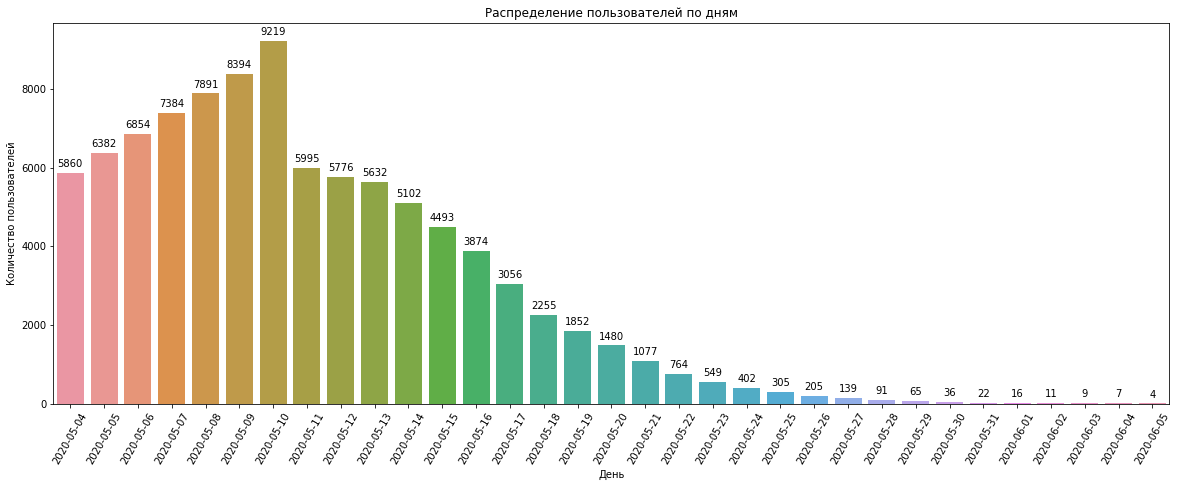

In [15]:
plt.figure(figsize=(20, 7))
ax = sns.barplot(data = dau_total, x = 'event_date', y = 'user_id')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.grid(False)
plt.title('Распределение пользователей по дням')      
plt.ylabel('Количество пользователей')
plt.xlabel('День')
ax.set_xticklabels(dau_total['event_date'])
plt.xticks(rotation = 60)
plt.show()

До 10 мая наблюдается рост количества пользователей в день, затем идет резкий спад. Данный спад может быть связан с окончанием майских праздников, а также с окончанием периода проведения рекламной кампании.

Изучим распределения событий по дням 

In [16]:
events_per_day = game_actions.groupby('event_date')['event'].count().reset_index()

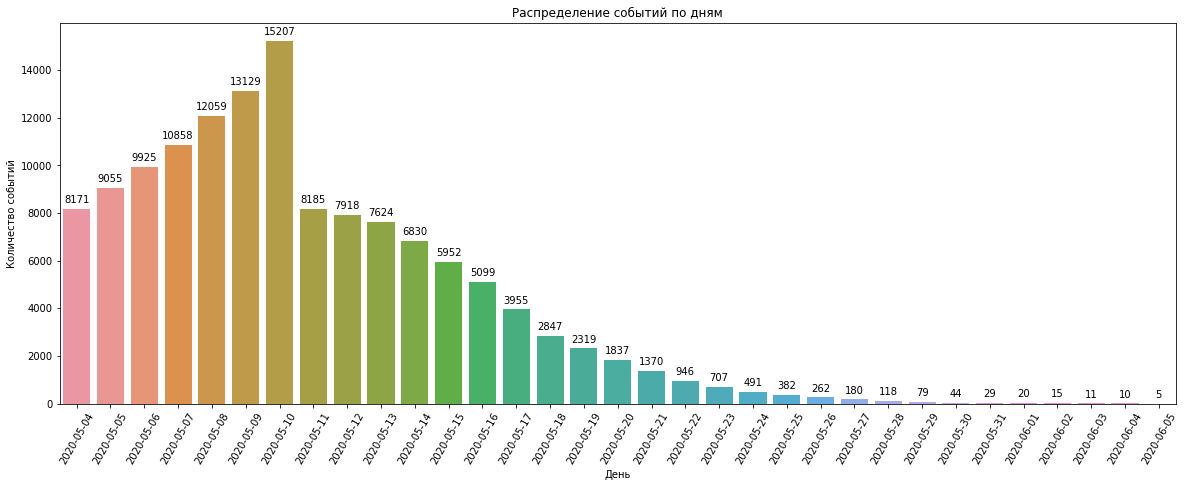

In [17]:
plt.figure(figsize=(20, 7))
ax = sns.barplot(data = events_per_day, x = 'event_date', y = 'event')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.grid(False)
plt.title('Распределение событий по дням')      
plt.ylabel('Количество событий')
plt.xlabel('День')
ax.set_xticklabels(events_per_day['event_date'])
plt.xticks(rotation = 60)
plt.show()

Тенденция в распределении событий по дням аналогичная распределению пользователей по дням

Определеним, сколько в среднем событий приходится на 1-го пользователя

In [18]:
events_per_user = game_actions.groupby('user_id').agg({'event': 'count'}).mean()
display('Среднее количество событий на 1-го пользователя: {}'.format(int(events_per_user)))

'Среднее количество событий на 1-го пользователя: 9'

Посмотрим на распределение в общем объеме пользователей, не прошедших 1-й уровень, пользователей, завершивших 1-й уровень путем реализации проекта, и пользователей, завершивших 1-й уровень путем победы над первым врагом 

In [19]:
builders_winners = (
    game_actions.query('project_type == "satellite_orbital_assembly"')
    ['user_id'].to_list()
)
enemy_winners = (
    game_actions.query('(event == "finished_stage_1") and (user_id != @builders_winners)')
    ['user_id'].to_list()
)
loosers = (
    list(game_actions.query('(user_id != @builders_winners) and (user_id != @enemy_winners)')
    ['user_id'].unique())
)
display('Общее количество пользователей:{:.0f}'.format(len(loosers) + len(builders_winners) + len(enemy_winners)))
display('Количество пользователей, не прошедших 1-й уровень:{:.0f}'.format(len(loosers)))
display('Количество пользователей, прошедших 1-й уровень:{:.0f}'.format(len(builders_winners) + len(enemy_winners)))        
display('Количество пользователей, прошедших 1-й уровень, реализовав проект:{:.0f}'.format(len(builders_winners)))     
display('Количество пользователей, прошедших 1-й уровень, победив врага:{:.0f}'.format(len(enemy_winners)))   

'Общее количество пользователей:13576'

'Количество пользователей, не прошедших 1-й уровень:7759'

'Количество пользователей, прошедших 1-й уровень:5817'

'Количество пользователей, прошедших 1-й уровень, реализовав проект:1866'

'Количество пользователей, прошедших 1-й уровень, победив врага:3951'

Определим среднее количество построенных зданий для тех пользователей, кто завершил 1-й уровень(победой над врагом или реализацией проекта), и тех, кто не завершил первый уровень

Для пользователей, завершивших 1-й уровень, реализовав проект

In [20]:
builders = (
    game_actions.query('project_type == "satellite_orbital_assembly"')
    ['user_id'].unique()
)
avg_buildings = (
    game_actions[game_actions['user_id'].isin(builders)].groupby('user_id')
    .agg({'building_type':'count'}).mean()
)
display('Среднее количество построенных зданий:', round(avg_buildings, 0))

'Среднее количество построенных зданий:'

building_type    13.0
dtype: float64

Для пользователей, завершивших 1-й уровень, победив врага

In [21]:
enemy_win = game_actions.query('event == "finished_stage_1"')['user_id'].unique()
avg_buildings = (
    game_actions[game_actions['user_id'].isin(enemy_win)].groupby('user_id')
    .agg({'building_type':'count'}).mean()
)
display('Среднее количество построенных зданий:', round(avg_buildings, 0))

'Среднее количество построенных зданий:'

building_type    10.0
dtype: float64

Для пользователей, незавершивших 1-й уровень

In [22]:
loosers = (
    game_actions
    .query('(event != "finished_stage_1") or (project_type != "satellite_orbital_assembly")')
    ['user_id'].unique()
)
avg_buildings = (
    game_actions[game_actions['user_id'].isin(loosers)].groupby('user_id')
    .agg({'building_type':'count'}).mean()
)
display('Среднее количество построенных зданий:', round(avg_buildings,0))

'Среднее количество построенных зданий:'

building_type    9.0
dtype: float64

Посмотрим распределение расходов по типам рекламных источников

In [23]:
source_cost_by_channel = (
    ad_costs.groupby('source')['cost'].sum().astype('int')
    .reset_index().sort_values('cost', ascending = False)
)
display(source_cost_by_channel)
display('Общая сумма расходов на рекламу: {:.0f}' .format(ad_costs['cost'].sum()))

,source,cost
2,yandex_direct,2233
1,instagram_new_adverts,2161
0,facebook_ads,2140
3,youtube_channel_reklama,1068


'Общая сумма расходов на рекламу: 7604'

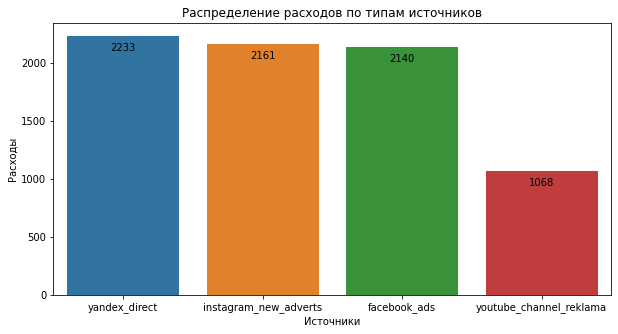

In [24]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('Распределение расходов по типам источников')
ax = sns.barplot(data = source_cost_by_channel, x = 'source', y = 'cost', errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel('Расходы')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

Изучим распределение пользователей в зависимости от источника рекламы

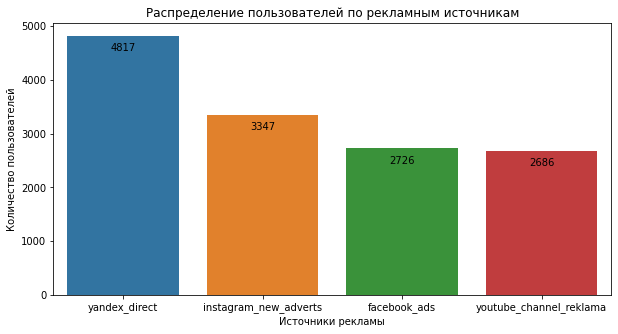

In [25]:
users_by_source = (
    user_source.groupby('source')['user_id'].count().reset_index()
    .sort_values('user_id', ascending = False)
)
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('Распределение пользователей по рекламным источникам')
ax = sns.barplot(data = users_by_source, x = 'source', y = 'user_id', errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.ylabel('Количество пользователей')
plt.xlabel('Источники рекламы')
plt.xticks(rotation = 0)
plt.show()

Рассчитаем САС по каждому рекламному источнику - стоимость привлечения одного пользователя

In [26]:
cost_source = (
    pd.merge(source_cost_by_channel , users_by_source, on = 'source').
    rename(columns = {'user_id' : 'users_number'})
)
cost_source['cac'] = round((cost_source['cost'] / cost_source['users_number']),2)
display(cost_source.sort_values(by='cac', ascending=False))

,source,cost,users_number,cac
2,facebook_ads,2140,2726,0.79
1,instagram_new_adverts,2161,3347,0.65
0,yandex_direct,2233,4817,0.46
3,youtube_channel_reklama,1068,2686,0.40


**Вывод:**
- данные по действиям пользователей представлены за период с 4 мая по 5 июня 2020 года;
- затрат на рекламу осуществлялись в период с 3 по 9 мая 2020 года. Мы имеем дело с предоплатной схемой;
- до 10 мая наблюдается ежедневный рост количества пользователей, затем идет резкий спад.  Пик пользователей 10 мая - более 9 тысяч. Pезкий спад после 10 мая спад может быть связан с окончанием майских праздников, а также с окончанием периода проведения рекламной кампании;
- тенденция в распределении событий по дням аналогичная распределению пользователей по дням. Пик событий приходится на 10 мая - более 15 тысяч, потом спад;
- Общее количество пользователей - 13576. Из них  - 7759 пользователй (57%) не завершили 1-й уровень; 5817 пользователей (43%) завершили первый уровень, из которых 68% победили врага и 32% реализовали проект. Мы видим, что пользователи предпочтитают более быструю стратегию завершения первого уровня - победа врага.
- среднее количество построенных зданий находится в интервале ло 9 до 13 в зависимости от завершения/незавершения 1-го уровня и стратегии пользователей;
- oбщая сумма расходов на рекламу - 7604;
- больше всего затрат падает на источник -  yandex_direct, источник с наименьшими затратами - 	youtube_channel_reklama;
- стоимость привлечения пользователей САС находится в интревале от 0.4 до 0.79. Самая высокая стоимость привлечения пользователей источника facebook_ads, самая низкая - youtube_channel_reklama.

## Проверка статистических гипотез

### Гипотеза 1: Среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается

Нулевая гипотеза: Среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, одинаково.

Альтернативная гипотеза: Среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается. 

Если p-value меньше порогового значения alpha=0.05, нулевую гипотезу отвергаем. 

Расчет времени, которое пользователи проводят в игре

In [27]:
min_date = (
    game_actions.groupby('user_id')['event_date']
    .min().reset_index().rename(columns = {'event_date' : 'min_date'})
)
max_date = (
    game_actions.groupby('user_id')['event_date']
    .max().reset_index().rename(columns = {'event_date' : 'max_date'})
)
maxmin_date = pd.merge(min_date, max_date, how = 'left', on = 'user_id')
maxmin_date['delta_time'] = (
    (maxmin_date['max_date'] - maxmin_date['min_date'])
    .astype('timedelta64[D]')
)

In [28]:
builders_winners_time = maxmin_date.query('user_id == @builders_winners')
enemy_winners_time = maxmin_date.query('user_id == @enemy_winners')

In [29]:
alpha = 0.05
results = (
    st.ttest_ind(builders_winners_time['delta_time'], 
    enemy_winners_time['delta_time'], equal_var = False)
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

p-значение: 6.5704667556440105e-105
Отвергаем нулевую гипотезу


**Вывод:**
- Среднее время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, различается. 

### Гипотеза 2: Количество построенных зданий у пользователей, которые заканчивают уровень через реализацию проекта, и пользователей, которые заканчивают уровень победой над другим игроком, различается

Нулевая гипотеза: Среднее количество построенных зданий у пользователей, которые заканчивают уровень через реализацию проекта, и пользователей, которые заканчивают уровень победой над другим игроком, не различается

Альтернативная гипотеза: Среднее количество построенных зданий у пользователей, которые заканчивают уровень через реализацию проекта, и пользователей, которые заканчивают уровень победой над другим игроком, различается

Если p-value меньше порогового значения alpha=0.05, нулевую гипотезу отвергаем. 

In [30]:
total_events_by_users = (
    game_actions.query('(event != "project") and (event != "finished_stage_1")')
    .groupby(['user_id'])['event'].count().reset_index()     
)
builders_winners_build = total_events_by_users.query('user_id == @builders_winners')
enemy_winners_build = total_events_by_users.query('user_id == @enemy_winners')

In [31]:
alpha = 0.05
results = (
    st.ttest_ind(builders_winners_build['event'], enemy_winners_build['event'],
    equal_var = False)
)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

p-значение: 0.0
Отвергаем нулевую гипотезу


**Вывод:**
- Среднее количество построенных зданий у пользователей, которые заканчивают уровень через реализацию проекта, и пользователей, которые заканчивают уровень победой над другим игроком, различается

## Оценка базовой модели монетизации 

Базовая модель монетизации предполагает показ рекламы на экране выбора постройки

Рассчитаем максимально возможную прибыль от рекламы  -  показ рекламы на экране при каждом выборе постройки. Доход от показа одной рекламы -  0.07 у.е

Смерджим две таблицы - game_actions и user_source

In [32]:
table_merged = game_actions.merge(user_source, how='left', on='user_id')
table_merged.head()

,event_datetime,event,building_type,user_id,project_type,event_date,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,yandex_direct


Добавим в table_merged столбец с доходом от 1-го показа рекламного ролика 

In [33]:
table_merged['income'] = 0.07
table_merged.head()

,event_datetime,event,building_type,user_id,project_type,event_date,source,income
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,youtube_channel_reklama,0.07
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,facebook_ads,0.07
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,instagram_new_adverts,0.07
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,facebook_ads,0.07
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,yandex_direct,0.07


Расчитаем прибыль источников

In [34]:
profit_source_max = (
    table_merged.query('event == "building"')
    .groupby('source', as_index=False)['income'].sum()
)
profit_source_max = profit_source_max.merge(cost_source[['source', 'cost']], on='source')
profit_source_max['profit'] = profit_source_max['income'] - profit_source_max['cost']
display(profit_source_max)

,source,income,cost,profit
0,facebook_ads,1829.17,2140,-310.83
1,instagram_new_adverts,2227.05,2161,66.05
2,yandex_direct,3152.24,2233,919.24
3,youtube_channel_reklama,1748.46,1068,680.46


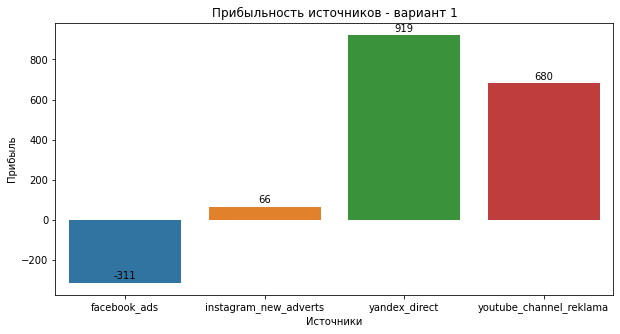

In [35]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('Прибыльность источников - вариант 1')
ax = sns.barplot(data = profit_source_max, x = 'source', y = 'profit', errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('Прибыль')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

In [36]:
display('Общая прибыль вариант 1: {:.0f}' .format(round(profit_source_max['profit'].sum(), 2)))

'Общая прибыль вариант 1: 1355'

- общая прибыль от показа рекламы при каждом выборе постройки - 1355;
- первое место по прибыльности занимает источник yandex_direct,  в то время как по источнику facebook_ads затраты превышают доходы (убыток).

Рассчитаем прибыль от рекламы при её показе на экране выбора постройки, начиная со второй постройки

In [37]:
profit_source_second = (
                       (table_merged.query('event == "building"')
                        .groupby('user_id', as_index=False)['event'].count())
)
profit_source_second['event'] = profit_source_second['event'] - 1
profit_source_second = (
    profit_source_second.query('event > 0')
    .rename(columns={'event':'build_number'})
)

In [38]:
profit_source_second['income'] = profit_source_second['build_number'] * 0.07 

In [39]:
profit_source_second = profit_source_second.merge(user_source, on='user_id')
profit_source_second = profit_source_second.groupby('source', as_index=False)['income'].sum()
display(profit_source_second.head())

,source,income
0,facebook_ads,1638.35
1,instagram_new_adverts,1992.76
2,yandex_direct,2815.05
3,youtube_channel_reklama,1560.44


In [40]:
profit_source_second  = profit_source_second.merge(cost_source[['source', 'cost']], on='source')
profit_source_second['profit'] = profit_source_second['income'] - profit_source_second['cost']
display(profit_source_second.head())

,source,income,cost,profit
0,facebook_ads,1638.35,2140,-501.65
1,instagram_new_adverts,1992.76,2161,-168.24
2,yandex_direct,2815.05,2233,582.05
3,youtube_channel_reklama,1560.44,1068,492.44


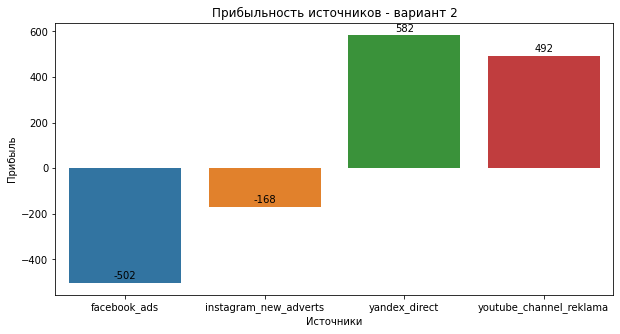

In [41]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('Прибыльность источников - вариант 2')
ax = sns.barplot(data = profit_source_second, x = 'source', y = 'profit', errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('Прибыль')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

In [42]:
display('Общая прибыль вариант 2: {:.0f}' .format(round(profit_source_second['profit'].sum(), 2)))

'Общая прибыль вариант 2: 405'

- общая прибыль от показа рекламы при каждом выборе постройки - 405;
- источники facebook_ads и instagram_new_advertsзатраты ушли в минус (завтраты превышают доходы), yandex_direct и youtube_channel_reklama принесли прибыль 582 и 492 у.е соответственно.

Рассчитаем прибыль от рекламы при её показе на экране выбора постройки, начиная с третьей постройки

In [43]:
profit_source_third = (
                     (table_merged.query('event == "building"')
                      .groupby('user_id', as_index=False)['event'].count())
)
profit_source_third['event'] = profit_source_third['event'] - 2
profit_source_third = profit_source_third.query('event > 0').rename(columns={'event':'build_number'})

In [44]:
profit_source_third['income'] = profit_source_third['build_number'] * 0.07 

In [45]:
profit_source_third = profit_source_third.merge(user_source, on='user_id')
profit_source_third = profit_source_third.groupby('source', as_index=False)['income'].sum()
display(profit_source_third.head())

,source,income
0,facebook_ads,1448.51
1,instagram_new_adverts,1759.24
2,yandex_direct,2479.19
3,youtube_channel_reklama,1373.33


In [46]:
profit_source_third  = profit_source_third.merge(cost_source[['source', 'cost']], on='source')
profit_source_third ['profit'] = profit_source_third ['income'] - profit_source_third ['cost']
display(profit_source_third.head())

,source,income,cost,profit
0,facebook_ads,1448.51,2140,-691.49
1,instagram_new_adverts,1759.24,2161,-401.76
2,yandex_direct,2479.19,2233,246.19
3,youtube_channel_reklama,1373.33,1068,305.33


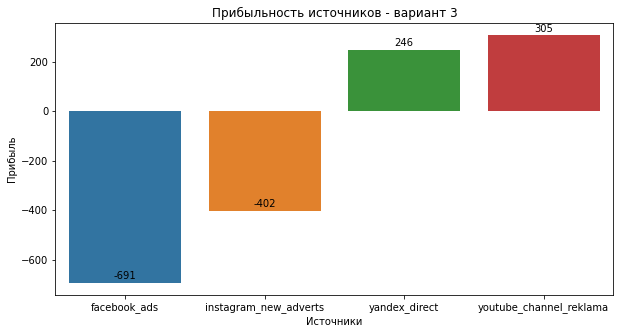

In [47]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('Прибыльность источников - вариант 3')
ax = sns.barplot(data = profit_source_third, x = 'source', y = 'profit', errwidth=0)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('Прибыль')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

In [48]:
display('Общая прибыль вариант 3: {:.0f}' .format(round(profit_source_third['profit'].sum(), 2)))

'Общая прибыль вариант 3: -542'

- общий убыток - 542;
- источники facebook_ads и instagram_new_advertsзатраты ушли в большой минус (завтраты превышают доходы), yandex_direct и youtube_channel_reklama принесли небольшую  прибыль 246 и 305 у.е соответственно.

**Вывод:**
- максимальная общая прибыль достигается при базовой модели монетизации при показе рекламы перед выбором каждой постройки;
- порогом общей рентабельности служит модель, при  которой показ рекламы начинается с выбором второй постройки;
- при показе рекламы начиная с выбора третьей постройки мы уходим в минус и получаем общий убыток.

## Анализ модели монетизации с точки зрения окупаемости - расчет ROMI

Рассчитаем ROMI (выручка от рекламы/затраты на рекламу) для каждого источника для базовой модели Вариант 1 (варианты из раздела 5 "Оценка базовой модели монетизации")

In [49]:
profit_source_max['romi_%']=profit_source_max['income']/profit_source_max ['cost']*100
display(round(profit_source_max, 0))

,source,income,cost,profit,romi_%
0,facebook_ads,1829.0,2140,-311.0,85.0
1,instagram_new_adverts,2227.0,2161,66.0,103.0
2,yandex_direct,3152.0,2233,919.0,141.0
3,youtube_channel_reklama,1748.0,1068,680.0,164.0


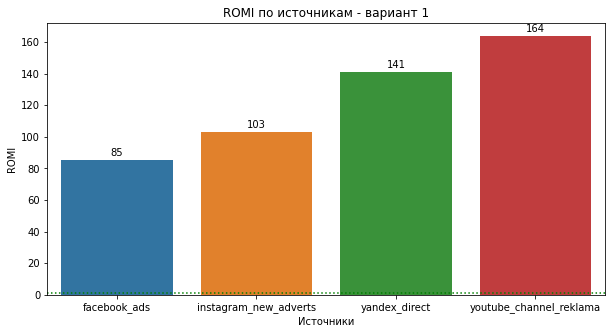

In [50]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('ROMI по источникам - вариант 1')
ax = sns.barplot(data = profit_source_max, x = 'source', y = 'romi_%', errwidth=0)
plt.axhline(y=1, color='g', linestyle=':')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('ROMI')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

Рассчитаем ROMI для каждого источника для модели Вариант 2

In [51]:
profit_source_second['romi_%']=profit_source_second['income']/profit_source_second['cost']*100
display(round(profit_source_second, 0))

,source,income,cost,profit,romi_%
0,facebook_ads,1638.0,2140,-502.0,77.0
1,instagram_new_adverts,1993.0,2161,-168.0,92.0
2,yandex_direct,2815.0,2233,582.0,126.0
3,youtube_channel_reklama,1560.0,1068,492.0,146.0


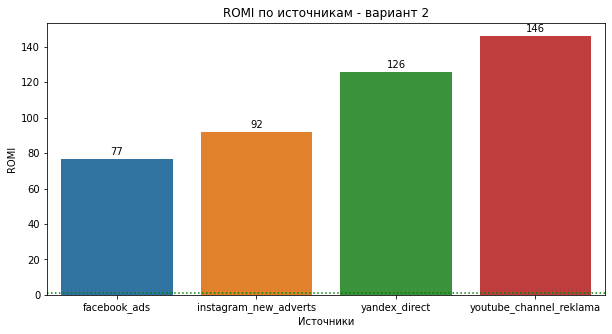

In [52]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('ROMI по источникам - вариант 2')
ax = sns.barplot(data = profit_source_second, x = 'source', y = 'romi_%', errwidth=0)
plt.axhline(y=1, color='g', linestyle=':')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('ROMI')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

Рассчитаем ROMI для каждого источника для модели Вариант 3

In [53]:
profit_source_third['romi_%']=profit_source_third['income']/profit_source_third['cost']*100
display(round(profit_source_third),0)

,source,income,cost,profit,romi_%
0,facebook_ads,1449.0,2140,-691.0,68.0
1,instagram_new_adverts,1759.0,2161,-402.0,81.0
2,yandex_direct,2479.0,2233,246.0,111.0
3,youtube_channel_reklama,1373.0,1068,305.0,129.0


0

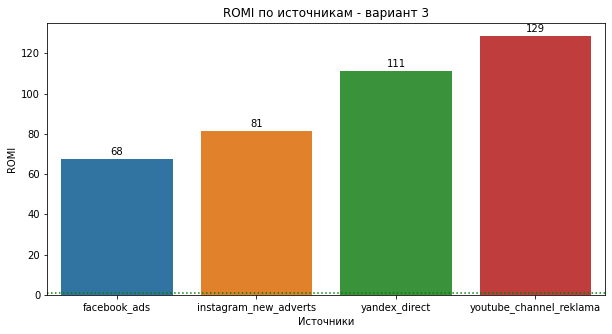

In [54]:
plt.figure(figsize=(10, 5))
plt.grid(False)
plt.title('ROMI по источникам - вариант 3')
ax = sns.barplot(data = profit_source_third, x = 'source', y = 'romi_%', errwidth=0)
plt.axhline(y=1, color='g', linestyle=':')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
plt.ylabel('ROMI')
plt.xlabel('Источники')
plt.xticks(rotation = 0)
plt.show()

**Вывод:**
- при модели монетизации с показом рекламы перед выбором каждой постройки окупаются три источника из четыреx. И только facebook_ads немного не дотягивает до 100% окупаемости;
- при модели монетизации с показом рекламы начиная со второй постройки окупаются два источника из четыреx - yandex_direct и youtube_channel_reklama. 	Чуть не дотягивает до окупаемости instagram_new_advertsдотягивает 92%. Facebook_ads окупается только на 77%;
- при модели монетизации с показом рекламы начиная с третьей постройки окупаются два источника из четыреx - yandex_direct и youtube_channel_reklama. Instagram_new_adverts и Facebook_ads уходят все дальше от точки окупаемости.

## Общий вывод и рекомендации по модели монетизации

<div style="border: solid green 2px; padding: 20px">
    
**В результате проведенного анализа имеющихся данных мы можем сформулировать следующие выводы:**
- общее количество пользователей за период с 04 мая по 05 июня 2020 года - 13576. Из них  - 7759 пользователй (57%) не завершили 1-й уровень; 5817 пользователей (43%) завершили первый уровень, из которых 68% победили врага и 32% реализовали проект;
- до 10 мая наблюдался ежедневный рост количества пользователей, далее резкий спад.  Пик пользователей пришелся на 10 мая - более 9 тысяч. Pезкий спад после 10 мая спад может быть связан с окончанием майских праздников, а также с окончанием периода проведения рекламной кампании (с 03 по 9 мая 2020 года);
- тенденция в распределении событий по дням аналогичная распределению пользователей по дням. Пик событий приходится на 10 мая - более 15 тысяч, потом спад;
- среднее количество построенных зданий находится в интервале от 9 до 13 в зависимости от завершения/незавершения 1-го уровня и стратегии пользователей;
- oбщая сумма расходов на рекламу - 7604;
- больше всего затрат падает на источник -  yandex_direct, источник с наименьшими затратами - 	youtube_channel_reklama;
- стоимость привлечения пользователей САС находится в интревале от 0.4 до 0.79. Самая высокая стоимость привлечения пользователей источника facebook_ads, самая низкая - youtube_channel_reklama.

<div style="border: solid green 2px; padding: 20px">

**Рекомендации по модели монетизации:**
- в связи с тем, что основным событием в игре является постройка зданий, наиболее оптимальным моментом для показа рекламы является момент выбора пользователем объекта постройки. Это менее раздражающий для юзеров момент, если сравнивать, например, c моментом хода самого процесса строительства объекта;
- максимальная общая прибыль достигается при базовой модели монетизации при показе рекламы перед выбором каждой постройки. При данном варианте также три источника (yandex_direct, youtube_channel_reklama,instagram_new_adverts)  из четырех окупаются. И только facebook_ads немного не дотягивает до 100% окупаемости. Порогом общей рентабельности служит модель, при  которой показ рекламы начинается с выбором второй постройки; окупаемость источников падает. При показе рекламы начиная с выбора третьей постройки мы уходим в минус и получаем общий убыток c увеличивающимся падением окупаемости источников.
- учитывая вышеизложенное можем рекомендовать следующую стратегию: начать с базовой модели монетизации с показом рекламы при каждом выборе постройки и посмотреть на реакцию пользователей за определенный период времени. При наличии негативной реакции и значительного оттока пользователей перейти на второй вариант  - модель, при  которой показ рекламы начинается с выбором второй постройки. В данном случае пользователи уже успеют заинтересоваться игрой, что скорее всего отразится в положительном ключе на их лояльности к показу рекламы. И с точки зрения прибыли компания будет все еще в плюсе.
- с точки зрения расходов на рекламу по результатам проведенного анализа рекомендуем: - увеличить расходы на рекламу для пользователей источника  youtube_channel_reklama (самая низкая стомость привлечения пользователей, сохранение прибыльности при любом из трех вариантов модели монетизации, самая высокая окупаемость среди всех представленных источников);  - снизить расходы на рекламу источника facebook_ads, как мы можем видеть, большие инвестиции (28% от общего объема) в данный источник не приводят к соответствующим коммерческим результатам - убыток (расходы превышают доходы), самая большая стоимость привлечения пользователей, и как следствие недостижение точки окупаемости.